# Numpy based image classification for Soybean crops dataset

**Dataset:** [Weed Detection in Soybean Crops](https://https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops)


## Download dataset

In [0]:
!wget https://data.mendeley.com/archiver/3fmjm7ncc6?version=2 -O soybean.zip

In [0]:
!unzip soybean.zip

In [0]:
!unzip dataset.zip

## Importing all the librabray which we need

In [0]:
import cv2
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing
%matplotlib inline


## Generate data for training

In [0]:
DATASET_DIR='dataset/'

In [6]:
classes=os.listdir(DATASET_DIR)
print(classes)

['soil', 'broadleaf', 'soybean', 'grass']


In [7]:
data=[]
for cname in classes:
  path=os.path.join(DATASET_DIR,cname)
  imgs=os.listdir(path)
  data.extend([[os.path.join(path,imgname),cname] for imgname in imgs])
  print("{} : {}".format(cname,len(imgs)))

data=np.array(data)

soil : 3249
broadleaf : 1191
soybean : 7376
grass : 3520


In [0]:
random.shuffle(data)
X=np.array([cv2.resize(cv2.imread(imgname),(100,100)).reshape(-1) for imgname in data[:,0]])
y=data[:,-1]


### Visualise the data

In [0]:
def sample_images(train):
    r, c = 3,5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            img=train[i*c+j].reshape(100,100,3)
            #img=cv2.imread(img_path)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

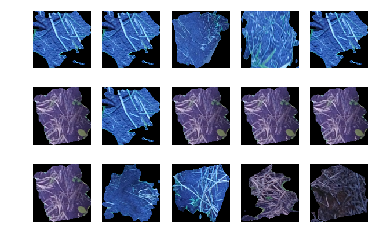

In [10]:
sample_images(X)

### Image augmentation using OpenCV

In [0]:
def rotate(image, angle=90, scale=1.0):
    w = image.shape[1]
    h = image.shape[0]
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    image = cv2.warpAffine(image,M,(w,h))
    return image

def flip(image, vflip=False, hflip=False):
    if hflip or vflip:
        if hflip and vflip:
            c = -1
        else:
            c = 0 if vflip else 1
        image = cv2.flip(image, flipCode=c)
    return image 


def image_augment(image):  
    aug=np.random.randint(3)
    img = image.copy()
    if aug ==1:
      img = flip(img, vflip=True, hflip=False)
    if aug ==2:
      img = flip(img, vflip=False, hflip=True)
    else:
      img = rotate(img)
    return img
  



In [0]:
X_aug=[]
y_aug=[]
for img,target in zip(X,y):
  X_aug.append(image_augment(img.reshape(100,100,3)).reshape(-1))
  y_aug.append(target)

X_aug=np.array(X_aug)
y_aug=np.array(y_aug)

In [0]:
y=np.hstack((y,y_aug))
X=np.vstack((X,X_aug))

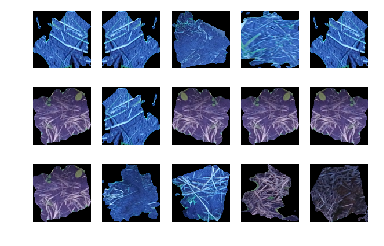

In [62]:
sample_images(X_aug)

### Generate Test and Training Data

**Encoding the target variable**

In [0]:
y=pd.get_dummies(y).values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Standard Scaler**

In [0]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

## Define Network

In [0]:
class network(object):
	"""docstring for network"""
	def __init__(self, input_shape,layers):
		super(network, self).__init__()
		self.layers = layers
		self.input_shape=input_shape
		self.initialize_parameters() 
		self.training=True

	def initialize_linear_layer(self,n_x, n_y):	
		W = np.random.randn(n_y, n_x) * 0.01
		b = np.zeros(shape=(n_y, 1))	
		
		assert(W.shape == (n_y, n_x))
		assert(b.shape == (n_y, 1))
		
		return W,b

	def initialize_parameters(self):
		input_dim=self.input_shape
		for i,layer  in enumerate(self.layers):
			if layer["type"]=="linear":
				output_dim=layer["output"]
				W,b=self.initialize_linear_layer(input_dim,output_dim)
				layers[i]["W"]=W
				layers[i]["b"]=b
				input_dim=output_dim
	

	def sigmoid(self,Z):
		s = 1 / (1 + np.exp(-Z))
		return s

	def sigmoid_backward(self,dA, Z):
		s = 1/(1+np.exp(-Z))
		dZ = dA * s * (1-s)
		assert (dZ.shape == Z.shape)
		return dZ

	def relu(self,Z):
		A = np.maximum(0,Z)
		assert(A.shape == Z.shape)
		return A

	def relu_backward(self,dA, Z):
		dZ = np.array(dA, copy=True) 
		dZ[Z <= 0] = 0
		assert (dZ.shape == Z.shape)
		return dZ
	
	def softmax(self,x):
		return np.exp(x) / np.sum(np.exp(x), axis=0)
	

	def linear_layer(self,x, W, b, activation):
		Z = W.dot(x) + b

		if activation == "sigmoid":
			A= self.sigmoid(Z)
		elif activation == "relu":
			A= self.relu(Z)
		
		assert (A.shape == (W.shape[0], x.shape[1]))
		
		return A,{"A":x, "W":W, "b":b, "Z":Z}	

	def linear_backward(self,dAL,grad_info,activation,m):
		if activation == "sigmoid":
			dZ= self.sigmoid_backward(dAL, grad_info["Z"])
		elif activation == "relu":
			dZ= self.relu_backward(dAL, grad_info["Z"])

		dW = 1./m * np.dot(dZ,grad_info["A"].T)
		db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
		dA_prev = np.dot(grad_info["W"].T,dZ)
		assert (dA_prev.shape == grad_info["A"].shape)
		assert (dW.shape == grad_info["W"].shape)
		assert (db.shape == grad_info["b"].shape)

		return dA_prev, dW, db
		


	def forward(self,A):
		for i,layer  in enumerate(self.layers):
			A_prev=A
			if layer["type"]=="linear":
				A,grad_info=self.linear_layer(A_prev, layer["W"], layer["b"], layer["activation"])
				if self.training:
					self.layers[i]["grad_info"]=grad_info
			elif layer["type"]=="softmax":
				A=self.softmax(A_prev)
		return A

	def backward(self,AL,Y,learning_rate):

		dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
		m = AL.shape[1]
		Y = Y.reshape(AL.shape) 
		
		for i in range(len(self.layers)-1,-1,-1):
			layer=self.layers[i]
			grad_info=layer["grad_info"]
			dAL, dW, db = self.linear_backward(dAL,grad_info,layer["activation"],m)
			layers[i]["W"]=layers[i]["W"] - learning_rate*dW
			layers[i]["b"]=layers[i]["b"] - learning_rate*db
				
		



In [0]:
def compute_cost(AL, Y):    
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    
    cost = np.squeeze(cost) 
    assert(cost.shape == ())
    
    return cost


In [0]:
def train_model(X, Y, learning_rate=0.0075, epochs=30,batch_size=256, print_cost=True): #lr was 0.009

    np.random.seed(1)
    costs = []                         
    steps=0
    for i in range(1, epochs+1):
      for j in range(0,X.shape[1]//batch_size):
          steps+=1
          X_batch=X[:,j*batch_size:(j+1)*batch_size]
          Y_batch=Y[:,j*batch_size:(j+1)*batch_size]
          #print(j,Y_batch.shape)
          AL=model.forward(X_batch)
          cost = compute_cost(AL, Y_batch)

          model.backward(AL,Y_batch,learning_rate)

          if print_cost and steps % 100 == 0:
              print ("Cost after iteration %i: %f" % (steps, cost))
              costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    

In [0]:
layers=[
		{
		"type":"linear",
		"output":1024,
		"activation":"relu",
	},

		{
		"type":"linear",
		"output":512,
		"activation":"relu",
	},

		{
		"type":"linear",
		"output":4,
		"activation":"sigmoid",
	}
]


In [0]:
input_shape=X_train.shape[1]
model=network(input_shape,layers)

Cost after iteration 100: 0.569054
Cost after iteration 200: 0.277454
Cost after iteration 300: 0.245423
Cost after iteration 400: 0.152937
Cost after iteration 500: 0.199851
Cost after iteration 600: 0.083262
Cost after iteration 700: 0.164278
Cost after iteration 800: 0.049273
Cost after iteration 900: 0.027398


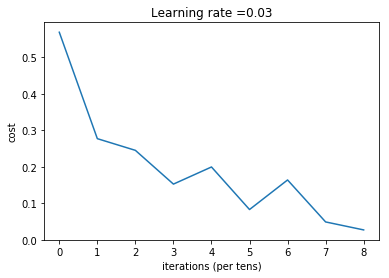

In [46]:
train_model(X_train.T, y_train.T, learning_rate=0.03,epochs=5,batch_size=128, print_cost=True)

## Test Accuracy

In [0]:
def Accuracy(y,y_pred):
  return np.sum(np.argmax(y_pred,axis=1)==np.argmax(y,axis=1))*100/np.argmax(y,axis=1).shape[0]

In [0]:
y_pred=model.forward(X_test.T).T

In [59]:
Accuracy(y_test,y_pred)

98.87530562347189